# Upload dataset

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
cd

C:\Users\zahra


# Extract data with SQL

In [3]:
data = pd.read_csv("Desktop/Data science BCG training/Projects/Customer Churn prediction and retention strategz/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
# Display basic info
data.info()

# Check for missing values
missing_values = data.isnull().sum()

# Convert 'TotalCharges' to numeric (it's stored as an object due to empty spaces)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Handle missing values (Fill with median)
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Remove duplicate rows if any (customerID should be unique)
data.drop_duplicates(subset=['customerID'], keep='first', inplace=True)

# Drop 'customerID' as it's not useful for predictions
data.drop(columns=['customerID'], inplace=True)

# Feature Engineering
# Create 'Tenure Category' based on tenure months
bins = [0, 6, 24, 60, np.inf]
labels = ['0-6 months', '6-24 months', '2-5 years', '5+ years']
data['TenureCategory'] = pd.cut(data['tenure'], bins=bins, labels=labels)

# Create 'MonthlyCharges to TotalCharges Ratio' (for spending trend)
data['ChargesRatio'] = data['MonthlyCharges'] / (data['TotalCharges'] + 1)  # Avoid division by zero


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


C:\Users\zahra\AppData\Local\Temp\ipykernel_12912\989430645.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


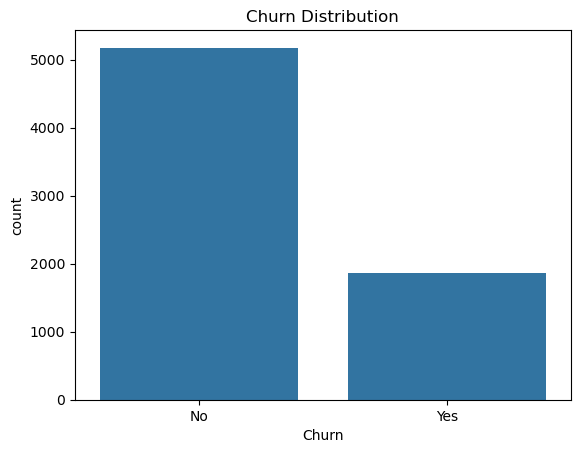

In [5]:
# Visualizing the distribution of the target variable
sns.countplot(x=data['Churn'])
plt.title("Churn Distribution")
plt.show()

In [6]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'TenureCategory',
       'ChargesRatio'],
      dtype='object')

In [7]:
# Convert 'Churn' column into a binary format where Yes = 1, No = 0
data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})
# Step 6: Identify categorical and numerical columns
# Separate columns based on data types to apply appropriate preprocessing.
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Ensure 'Churn' is not included in feature columns
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')
if 'Churn' in numerical_cols:
    numerical_cols.remove('Churn')
# Step 7: Preprocessing pipeline
# Numerical columns: Impute missing values and scale data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical columns: Apply one-hot encoding for categorical features.
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both transformations into a single preprocessing step.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)


# Identify categorical features (excluding the target variable)
categorical_features = data.select_dtypes(include=["object"]).columns.tolist()

# Use an 80-20 split to train the model and evaluate its performance.
X = data.drop(columns=['Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)
y_pred = rf_model.predict(X_test_processed)
y_proba = rf_model.predict_proba(X_test_processed)[:, 1]
# Step 12: Evaluate model performance
# Use accuracy, ROC-AUC, and classification report to measure performance.
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
classification_rep = classification_report(y_test, y_pred)
# Step 13: Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.7864
ROC-AUC Score: 0.8210
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [9]:
# For permutation importance
from sklearn.inspection import permutation_importance

# For SHAP
import shap

# ---- Permutation Importance ---- #
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation Importance")
plt.show()

# ---- SHAP Values ---- #
# Create an explainer with a sample of the training data
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot (global feature importance)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

# Explain a single prediction (for the first test sample)
sample = X_test.iloc[0:1]
shap.force_plot(explainer.expected_value[1], shap_values[1][0], sample, matplotlib=True)


c:\Users\zahra\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Male'